In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNetCV
import numpy as np
from sklearn.metrics import r2_score
import warnings
import math
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [4]:
df = pd.read_json('data/curated/FICS_MAIA.ndjson', lines = True)
#df = pd.read_json("data/raw/stockfish_150.ndjson", lines = True)
df = df.fillna(0)

In [5]:
print(len(df))
df = df[df['white'] != "?"]
df = df[df['black'] != "?"]
print(len(df))
df = df[df['stockfish_eval'].apply(lambda x: len(x) > 7)]
print(len(df))
df = df[df['white_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['stockfish_eval'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
print(len(df))
df = df[df['maia_cpl_w'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['maia_cpl_b'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
print(len(df))
df = df[df['result'] != "*"]
print(len(df))

df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')


df["ECO"] = df["ECO"].astype('category')
df["Opening"] = df["Opening"].astype('category')
df["result"] = df["result"].astype('category')

df["mean_elos"] = df[['white_elo', 'black_elo']].mean(axis=1)
df["diff_elos"] = df['white_elo'] - df['black_elo']

df['white_mean'] = df['white_cpl'].apply(np.mean)
df['white_std'] = df['white_cpl'].apply(np.std)
df['white_min'] = df['white_cpl'].apply(np.min)
df['white_max'] = df['white_cpl'].apply(np.max)

df['black_mean'] = df['black_cpl'].apply(np.mean)
df['black_std'] = df['black_cpl'].apply(np.std)
df['black_min'] = df['black_cpl'].apply(np.min)
df['black_max'] = df['black_cpl'].apply(np.max)

df['stockfish_mean'] = df['stockfish_eval'].apply(np.mean)
df['stockfish_std'] = df['stockfish_eval'].apply(np.std)
df['stockfish_min'] = df['stockfish_eval'].apply(np.min)
df['stockfish_max'] = df['stockfish_eval'].apply(np.max)

df['maia_w_mean'] = df['maia_cpl_w'].apply(np.mean)
df['maia_w_std'] = df['maia_cpl_w'].apply(np.std)
df['maia_w_min'] = df['maia_cpl_w'].apply(np.min)
df['maia_w_max'] = df['maia_cpl_w'].apply(np.max)

df['maia_b_mean'] = df['maia_cpl_b'].apply(np.mean)
df['maia_b_std'] = df['maia_cpl_b'].apply(np.std)
df['maia_b_min'] = df['maia_cpl_b'].apply(np.min)
df['maia_b_max'] = df['maia_cpl_b'].apply(np.max)

dep_var = "mean_elos" # 19955

12818
12818
12792
12792
12792
12792


In [6]:
# df.to_json('data/curated/FICS_MAIA_curated.ndjson', orient='records', lines=True)

In [119]:
cont = ['queen_moved_at', 'total_checks', 'first_check_at', 'queen_changed_at', 'total_moves', 'end_r',
 'end_p', 'end_b', 'end_n', 'end_q', 'end_N', 'end_P', 'end_Q', 'end_B', 'end_R', 'promotion', 'can_claim_draw',
 'white_mean', 'white_std', 'white_min', 'white_max', 'black_mean', 'black_std', 'black_min', 'black_max', 'stockfish_mean',
 'stockfish_std', 'stockfish_min', 'stockfish_max', 'maia_w_mean',
 'maia_w_std', 'maia_w_min', 'maia_w_max', 'maia_b_mean',
 'maia_b_std', 'maia_b_min', 'maia_b_max']

In [120]:
results = pd.get_dummies(df["result"])
openings = pd.get_dummies(df["Opening"])



X = pd.concat([df[cont], results, openings], axis = 1)
X = X.fillna(0)

num = 10000

y1 = df["mean_elos"]
y2 = df["diff_elos"]

# Y1 IS MEAN Y2 IS DIFF
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=10)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=10)


Looking at the cross validation results, it looks like 100 estimators is enough.

In [132]:
nums = [30, 50, 100, 150, 250, 350]

for num in nums:
    rf_mean = RandomForestRegressor(n_estimators=num, n_jobs=-1, min_samples_leaf=4, max_features=0.5, random_state=10)
    rf_mean.fit(X_train, y1_train)
    mean_pred_rf = rf_mean.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(f"Mean absolute errorL {mean_absolute_error(y1_test, mean_pred_rf)}")
    print(f"R squared score: {r2_score(y1_test, mean_pred_rf)}")
    print("----------------------------------")

RF model with 30 estimators.
Mean absolute errorL 179.89720842437777
R squared score: 0.17517041491263763
----------------------------------
RF model with 50 estimators.
Mean absolute errorL 179.49667809019465
R squared score: 0.18123821973292498
----------------------------------
RF model with 100 estimators.
Mean absolute errorL 179.41879587649748
R squared score: 0.18326314369304475
----------------------------------
RF model with 150 estimators.
Mean absolute errorL 178.84777773794426
R squared score: 0.18824171555498248
----------------------------------
RF model with 250 estimators.
Mean absolute errorL 178.4186086846357
R squared score: 0.19117410740782004
----------------------------------
RF model with 350 estimators.
Mean absolute errorL 178.40589146651482
R squared score: 0.19105954192659647
----------------------------------


Similarly, 100 estimators seems to be enough.

In [133]:
nums = [30, 50, 100, 150, 250, 350]

for num in nums:
    rf_diff = RandomForestRegressor(n_estimators=num, n_jobs=-1, min_samples_leaf=4, max_features=0.5, random_state=10)
    rf_diff.fit(X_train, y2_train)
    diff_pred_rf = rf_diff.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(f"Mean absolute errorL {mean_absolute_error(y2_test, diff_pred_rf)}")
    print(f"R squared score: {r2_score(y2_test, diff_pred_rf)}")
    print("----------------------------------")

RF model with 30 estimators.
Mean absolute errorL 124.53240071956121
R squared score: 0.15388766175194346
----------------------------------
RF model with 50 estimators.
Mean absolute errorL 123.64631848517162
R squared score: 0.15774394152107696
----------------------------------
RF model with 100 estimators.
Mean absolute errorL 123.24975444741328
R squared score: 0.16223951560167338
----------------------------------
RF model with 150 estimators.
Mean absolute errorL 123.0982340274152
R squared score: 0.16389230105759034
----------------------------------
RF model with 250 estimators.
Mean absolute errorL 122.90209035333966
R squared score: 0.16873288443370826
----------------------------------
RF model with 350 estimators.
Mean absolute errorL 122.7870042324402
R squared score: 0.17013591708143727
----------------------------------


c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: 

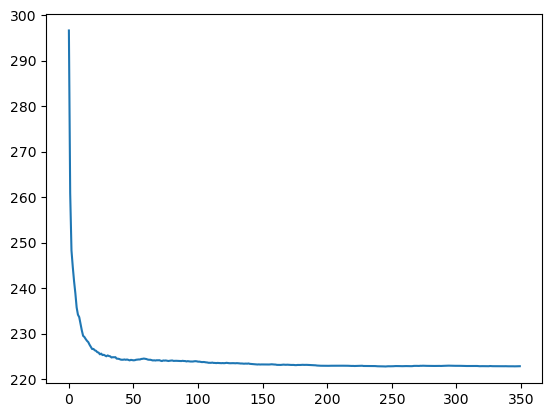

In [134]:
import matplotlib.pyplot as plt
preds = np.stack([t.predict(X_test) for t in rf_mean.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), y1_test) for i in range(350)]);

In [135]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

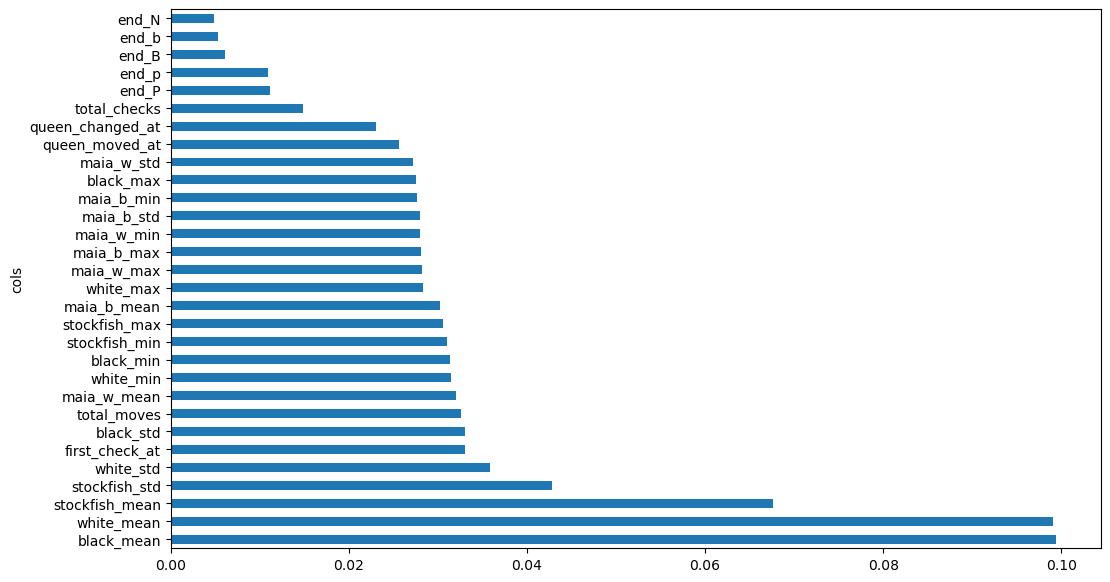

In [136]:
fi_mean = rf_feat_importance(rf_mean, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi_mean[:30]);

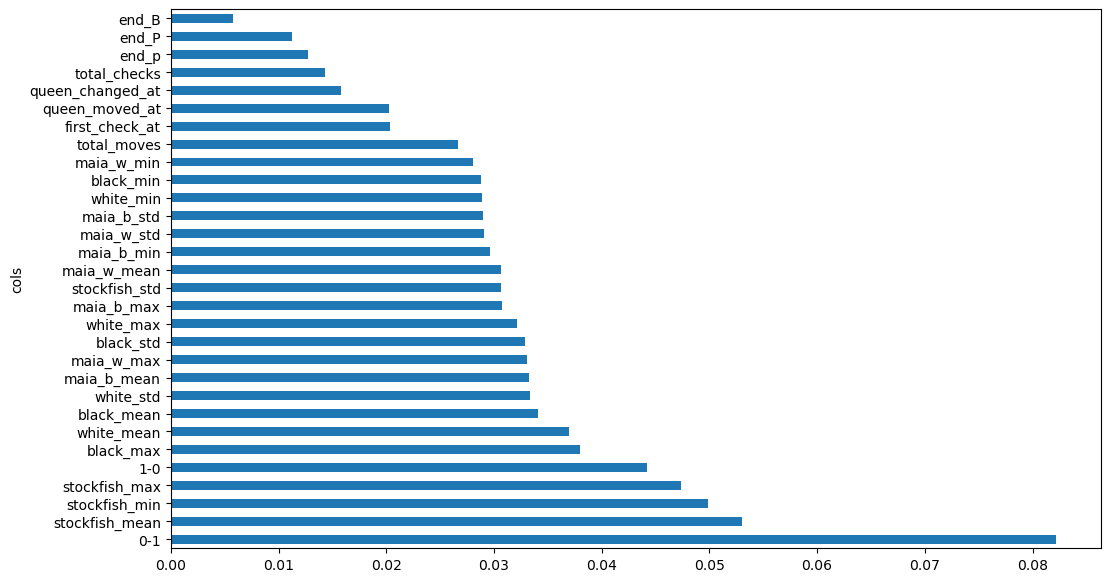

In [137]:
fi_diff = rf_feat_importance(rf_diff, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi_diff[:30]);

In [138]:
to_keep_diff = fi_diff[fi_diff.imp>0.01].cols
print(len(to_keep_diff))
print((to_keep_diff))

29
37                 0-1
25      stockfish_mean
27       stockfish_min
28       stockfish_max
38                 1-0
24           black_max
17          white_mean
21          black_mean
18           white_std
33         maia_b_mean
32          maia_w_max
22           black_std
20           white_max
36          maia_b_max
26       stockfish_std
29         maia_w_mean
35          maia_b_min
30          maia_w_std
34          maia_b_std
19           white_min
23           black_min
31          maia_w_min
4          total_moves
2       first_check_at
0       queen_moved_at
3     queen_changed_at
1         total_checks
6                end_p
11               end_P
Name: cols, dtype: object


In [142]:
to_keep_mean = fi_mean[fi_mean.imp>0.01].cols
print(len(to_keep_mean))
print((to_keep_mean))

27
21          black_mean
17          white_mean
25      stockfish_mean
26       stockfish_std
18           white_std
2       first_check_at
22           black_std
4          total_moves
29         maia_w_mean
19           white_min
23           black_min
27       stockfish_min
28       stockfish_max
33         maia_b_mean
20           white_max
32          maia_w_max
36          maia_b_max
31          maia_w_min
34          maia_b_std
35          maia_b_min
24           black_max
30          maia_w_std
0       queen_moved_at
3     queen_changed_at
1         total_checks
11               end_P
6                end_p
Name: cols, dtype: object


In [143]:
# Y1 IS MEAN Y2 IS DIFF
rf_mean = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_mean.fit(X_train[to_keep_mean], y1_train)
mean_pred_rf = rf_mean.predict(X_test[to_keep_mean])



rf_diff = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_diff.fit(X_train[to_keep_diff], y2_train)
dff_pred_rf = rf_diff.predict(X_test[to_keep_diff])

In [144]:
white_pred = []
black_pred = []

for i in range(len(dff_pred_rf)):
    white_pred.append(mean_pred_rf[i] + dff_pred_rf[i]/2)
    black_pred.append(mean_pred_rf[i] - dff_pred_rf[i]/2)


all_preds = white_pred + black_pred

In [145]:
len(all_preds)

5118

In [146]:
white_actual = []
black_actual = []

for ind in y1_test.index:
    white_actual.append(df.loc[ind]["white_elo"])
    black_actual.append(df.loc[ind]["black_elo"])


"""
for ind, row in df[num:].iterrows():
    white_actual.append(row["white_elo"])
    black_actual.append(row["black_elo"])
"""
all_actual = white_actual + black_actual


In [147]:
len(all_actual)

5118

In [148]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(all_actual, all_preds)

191.20081755679513

In [149]:
r2_score(all_actual, all_preds)

0.1784201752728083

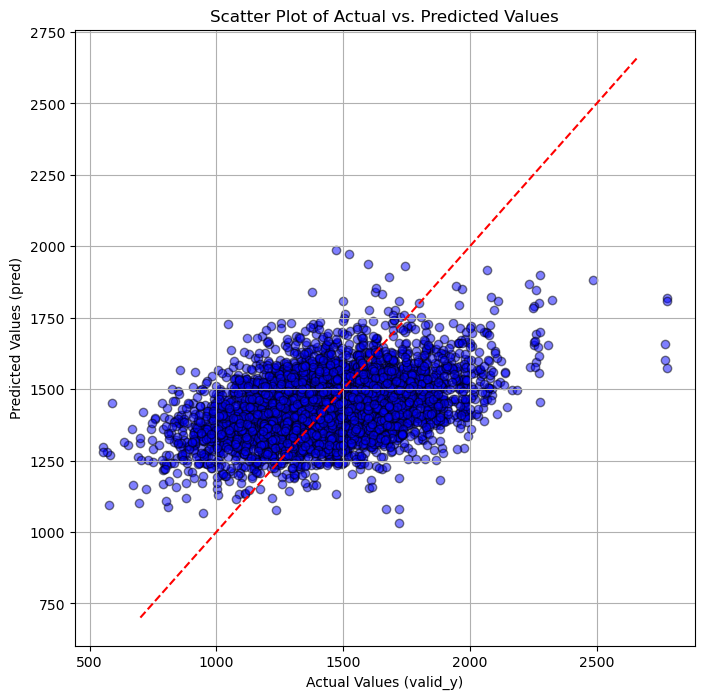

In [74]:
import matplotlib.pyplot as plt

# Assuming valid_y and pred are your actual and predicted values
# valid_y = [your actual values]
# pred = [your predicted values]

plt.figure(figsize=(8, 8))
plt.scatter((all_actual), (all_preds), edgecolor='k', color='b', alpha=0.5)

# Adding a diagonal line to indicate perfect predictions
plt.plot([min(y1), max(y1)], [min(y1), max(y1)], 'r--')

# Adding titles and labels
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.xlabel('Actual Values (valid_y)')
plt.ylabel('Predicted Values (pred)')

# Adding a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [150]:
print(mean_absolute_error(all_actual, all_preds))
print(r2_score(all_actual, all_preds))

191.20081755679513
0.1784201752728083


In [151]:
import joblib
results = pd.get_dummies(df["result"])

X = pd.concat([df[cont], results], axis = 1)
X = X.fillna(0)

y1 = df["mean_elos"]
y2 = df["diff_elos"]

rf_mean = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_mean.fit(X[to_keep_mean], y1)

rf_diff = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_diff.fit(X[to_keep_diff], y2)

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_jobs=-1)

In [152]:
X.columns

Index(['queen_moved_at', 'total_checks', 'first_check_at', 'queen_changed_at',
       'total_moves', 'end_r', 'end_p', 'end_b', 'end_n', 'end_q', 'end_N',
       'end_P', 'end_Q', 'end_B', 'end_R', 'promotion', 'can_claim_draw',
       'white_mean', 'white_std', 'white_min', 'white_max', 'black_mean',
       'black_std', 'black_min', 'black_max', 'stockfish_mean',
       'stockfish_std', 'stockfish_min', 'stockfish_max', 'maia_w_mean',
       'maia_w_std', 'maia_w_min', 'maia_w_max', 'maia_b_mean', 'maia_b_std',
       'maia_b_min', 'maia_b_max', '0-1', '1-0', '1/2-1/2'],
      dtype='object')

In [153]:

# Save the trained model to a file
joblib.dump(rf_mean, 'rf_mean.pkl')
joblib.dump(rf_diff, 'rf_diff.pkl')

['rf_diff.pkl']

# Lets see if modelling the elo directly is better

Let us judge by assessing the mae, mse, and r2 scores


In [ ]:
games = []
for index, row in df.iterrows():
    white = {
        "name": row["white"],
        "event": row["event"],
        "opening": row["Opening"],
        "elo": row["white_elo"],
        "stockfish_mean": row["white_mean"],
        "stockfish_min": row["white_min"],
        "stockfish_max": row["white_max"],
        "stockfish_std": row["white_std"],
        "maia_mean": row["maia_w_mean"],
        "maia_min": row["maia_w_min"],
        "maia_max": row["maia_w_max"],
        "maia_std": row["maia_w_std"],
        "result": row["result"],
        "is_white": 1,
        'moves': row["moves"]
    }

    black = {
        "name": row["black"],
        "event": row["event"],
        "opening": row["Opening"],
        "elo": row["black_elo"],
        "stockfish_mean": row["black_mean"],
        "stockfish_min": row["black_min"],
        "stockfish_max": row["black_max"],
        "stockfish_std": row["black_std"],
        "maia_mean": row["maia_b_mean"],
        "maia_min": row["maia_b_min"],
        "maia_max": row["maia_b_max"],
        "maia_std": row["maia_b_std"],
        "result": row["result"],
        "is_white": 0,
        'moves': row["moves"]
    }

    games.append(white)
    games.append(black)

In [ ]:
g = pd.DataFrame(games)

In [ ]:
g.to_json('data/curated/FICS_INDIVIDUAL.ndjson', orient='records', lines=True)

In [80]:
df = pd.read_json("data/curated/FICS_INDIVIDUAL.ndjson", lines=True)

In [81]:
df.columns

Index(['name', 'event', 'opening', 'elo', 'stockfish_mean', 'stockfish_min',
       'stockfish_max', 'stockfish_std', 'maia_mean', 'maia_min', 'maia_max',
       'maia_std', 'result', 'is_white', 'moves'],
      dtype='object')

In [102]:
cont = ['stockfish_mean', 'stockfish_min', 'stockfish_max', 'stockfish_std', 
        'maia_mean', 'maia_min', 'maia_max', 'maia_std']

results = pd.get_dummies(df["result"])
openings = pd.get_dummies(df["opening"])
is_white = pd.get_dummies(df["is_white"])

X = pd.concat([df[cont], results, openings], axis = 1)
X = X.fillna(0)

y = df["elo"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [103]:
nums = [30, 50, 100, 150, 250, 350]

for num in nums:
    rf_individual = RandomForestRegressor(n_estimators=num, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
    rf_individual.fit(X_train, y_train)
    individual_pred_rf = rf_individual.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(f"Mean absolute errorL {mean_absolute_error(y_test, individual_pred_rf)}")
    print(f"R squared score: {r2_score(y_test, individual_pred_rf)}")
    print("----------------------------------")

RF model with 30 estimators.
Mean absolute errorL 194.93256428108594
R squared score: 0.1191789183414741
----------------------------------
RF model with 50 estimators.
Mean absolute errorL 194.5271500323083
R squared score: 0.1205292819729662
----------------------------------
RF model with 100 estimators.
Mean absolute errorL 194.19303477769685
R squared score: 0.12230828685577289
----------------------------------
RF model with 150 estimators.
Mean absolute errorL 193.76091209284922
R squared score: 0.12824143172274716
----------------------------------
RF model with 250 estimators.
Mean absolute errorL 193.71586811740423
R squared score: 0.1284420760798577
----------------------------------
RF model with 350 estimators.
Mean absolute errorL 193.7506832743488
R squared score: 0.12790615360314006
----------------------------------


c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: 

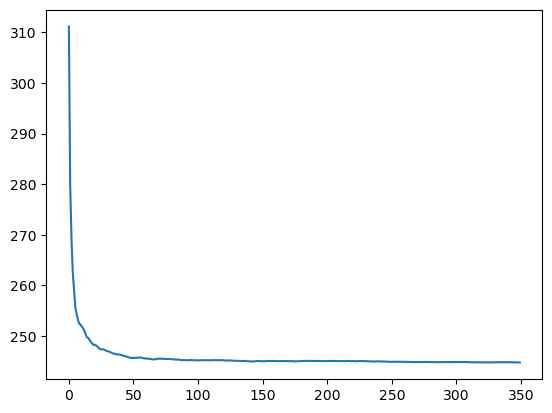

In [104]:
import matplotlib.pyplot as plt
preds = np.stack([t.predict(X_test) for t in rf_individual.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), y_test) for i in range(350)]);

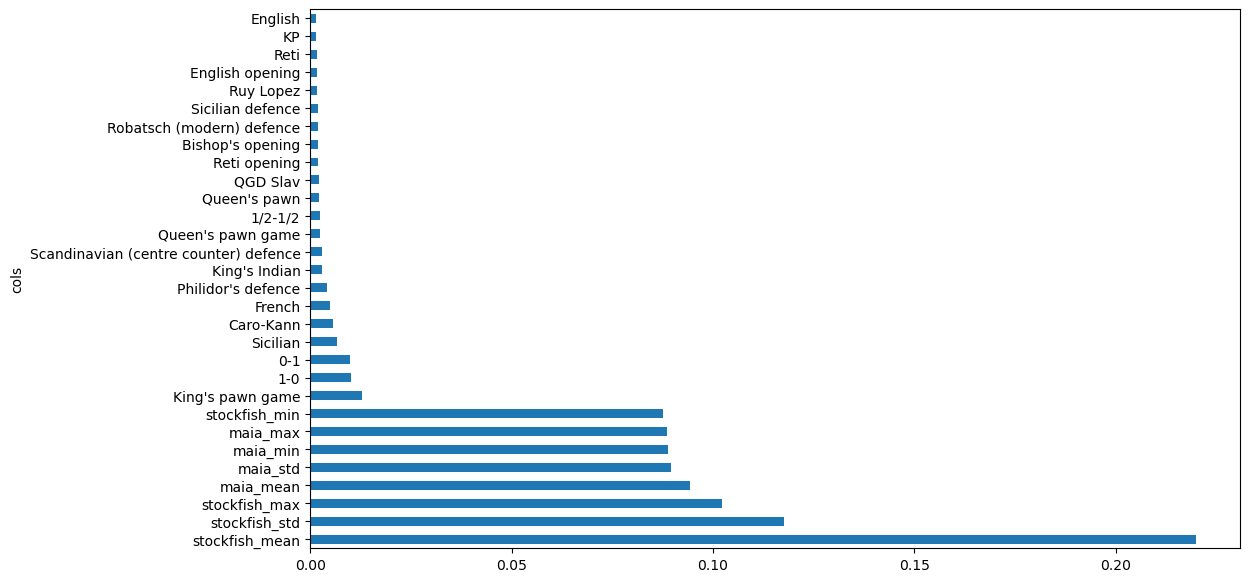

In [105]:
fi_individual = rf_feat_importance(rf_individual, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi_diff[:30]);

In [108]:
to_keep_individual = fi_individual[fi_individual.imp>0.01].cols
print(len(to_keep_individual))
print((to_keep_individual))

10
0        stockfish_mean
3         stockfish_std
2         stockfish_max
4             maia_mean
7              maia_std
5              maia_min
6              maia_max
1         stockfish_min
103    King's pawn game
9                   1-0
Name: cols, dtype: object


In [109]:
rf_individual = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_individual.fit(X_train[to_keep_individual], y_train)
individual_pred_rf = rf_individual.predict(X_test[to_keep_individual])
print(f"RF model with {100} estimators.")
print(f"Mean absolute errorL {mean_absolute_error(y_test, individual_pred_rf)}")
print(f"R squared score: {r2_score(y_test, individual_pred_rf)}")
print("----------------------------------")

RF model with 100 estimators.
Mean absolute errorL 196.77789992036736
R squared score: 0.10102712704741812
----------------------------------


In [110]:
joblib.dump(rf_individual, 'rf_individual.pkl')

['rf_individual.pkl']

# Conclusion

|Method |R2 Score |MAE |
|-----|-----|-----|
|Individual Prediction|0.101|196.77|
|Mean + Diff Prediction|0.178|191.20|

Ultimately, the use of mean and difference estimation provides an improvement over the direct estimation. Overall, I think it is a matter of opinion which method to use, there is definitely a complexity/performance tradeoff, however, I think the Mean and Diff prediction should be used.